In [1]:
import random
import math

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import tree
import joblib

import scipy

In [4]:
plt.rcParams["figure.figsize"] = (15, 17)

In [5]:
def convertFahrenheitToCelsius(f):
    return (f - 32) / 1.8

## load random forest model

In [6]:
filename_min = './min_random_forest_model.sav'
filename_max = './max_random_forest_model.sav'

In [7]:
rfr_min = joblib.load(filename_min)
rfr_max = joblib.load(filename_max)

## create test data from test dataset

In [8]:
pth_rf = '../processed_data/RF_model_test_data.csv'
df_rf = pd.read_csv(pth_rf)

In [9]:
df_rf.shape

(6, 16)

In [10]:
df_rf

,ID,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,TC,TS
0,4,1.77,68,-1,21.705129,24,24.797778,57.162,74.967033,37.323944,32.145839,0.267615,0.54,1.0,3,4
1,5,1.80,75,-1,23.148148,33,27.961111,41.130,69.000000,14.000000,31.719000,1.906977,0.31,1.0,5,5
2,10,1.63,50,1,18.818924,23,24.835000,60.040,76.582090,25.982456,30.008000,20.383879,0.31,2.5,3,6
3,12,1.62,56,1,21.338211,24,25.088889,53.862,98.000000,79.000000,31.456394,0.030935,0.61,1.8,4,5
4,14,1.77,68,-1,21.705129,24,24.652778,53.962,86.000000,57.000000,31.766986,0.019934,0.54,1.0,2,3
5,22,1.62,56,1,21.338211,24,25.671111,23.458,78.000000,38.000000,31.779339,0.034290,0.57,1.0,4,3


In [11]:
X_columns = ['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
              'heart_rate', 'stress_level', 'skin_temp', 'eda', \
              'Clo', 'Act']

In [12]:
X = df_rf[X_columns]
y = df_rf['env_temp']

## predict

### predict comfort zone min value

In [13]:
y_pred_min = rfr_min.predict(X)

### transfer to Celsius

In [14]:
y_pred_min

array([25.01105787, 24.34987963, 25.3478588 , 25.13504398, 24.50170718,
       24.05398495])

### predict comfort zone max value

In [15]:
y_pred_max = rfr_max.predict(X)

### transfer to Celsius

In [16]:
y_pred_max

array([26.71903125, 28.75644494, 25.79952331, 25.94563145, 26.70554167,
       26.24813046])

### detect error

In [17]:
errorIdx = []
for i in range(len(y_pred_min)):
    if y_pred_max[i] <= y_pred_min[i]:
        errorIdx.append(i)

In [18]:
errorIdx

[]

In [20]:
df_rf.iloc[errorIdx,:]

,ID,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,TC,TS


### delete the unacceptable values

In [21]:
t_min = []
t_max = []
for i in range(len(y_pred_min)):
    if y_pred_min[i] <= y_pred_max[i]:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_max[i])
    else:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_min[i])

In [22]:
len(t_min)

6

### plot zone

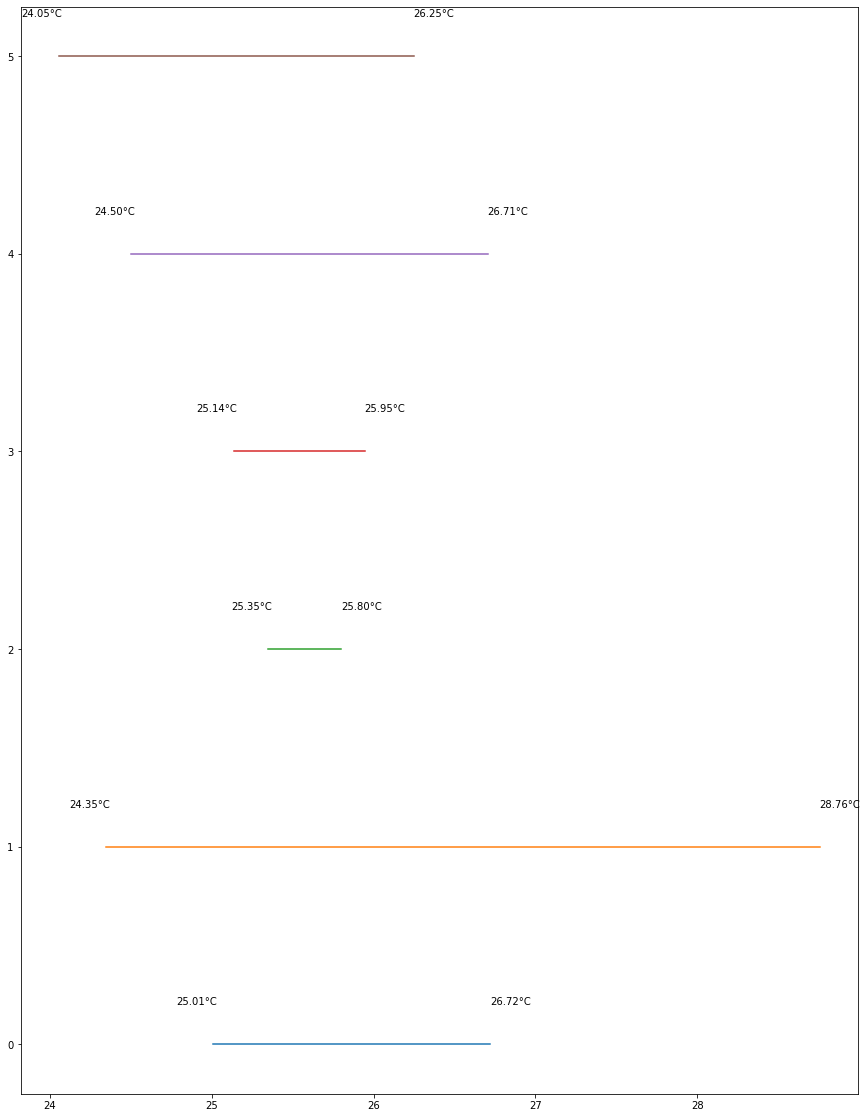

In [23]:
plt.rcParams["figure.figsize"] = (15, 20)
# draw comfort zone
for i in range(len(t_min)):
    plt.plot([t_min[i], t_max[i]],[i, i])
    
# tag comfort zone min $ max
for i in range(len(t_min)):
    plt.text(t_min[i]- 0.23, i+0.2, "%.2f°C" % t_min[i])
    plt.text(t_max[i], i+0.2, "%.2f°C" % t_max[i])

plt.show()

## predict group tempreture model

In [24]:
import math

class OptimalGroupTempreture():
    def __init__(self, minTs, maxTs, sensitivity=1.0, defaultMinMaxRange=1.0):
        """
        sensitivity > 0, less means more sensitive
        defaultMinMaxRange > 0 or == None
        """
        if len(minTs) != len(maxTs):
            print('Length of min tempreture records and max tempretur records are not equal!')
            return None
        self.minTs = minTs
        self.maxTs = maxTs
        self.sensitivity = sensitivity
        self.defaultMinMaxRange = defaultMinMaxRange
        self.otdDF = None
        self.optimalTargetTemperatureOTD = None
        self.max_otd = None
        self.min_otd = None
    
    def getTempreture(self, model='auto', sensitivePeoplePercentageLimit=0.1, sensitiveRange=2, ppd=0.1):
        """
        model = 'auto', 'sensitive first', 'otd model'
        sensitivePeoplePercentage is > 0 and < 1
        sensitiveRange is > 0, unit is Fahrenheit Degree
        ppd: only for OTD model
        """
        minTs = self.minTs
        maxTs = self.maxTs

        if self.defaultMinMaxRange is not None:
            avgTs = [(maxTs[i] + minTs[i]) / 2 for i in range(len(minTs))]
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                t = tRanges[i] if tRanges[i] > 0 else self.defaultMinMaxRange
                checkedtRanges.append(t)
        else:
            avgTs = []
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                if tRanges[i] > 0:
                    t = tRanges[i]
                    checkedtRanges.append(t)
                    avgTs.append((maxTs[i] + minTs[i]) / 2)

        # model selection
        if model == 'sensitive first':
            print('sensitive first model')
            targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        elif model == 'otd model':
            print('otd model')
            targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
        elif model == 'auto':
            lengthOfSensitivePeople = len([tRange for tRange in checkedtRanges if tRange <= sensitiveRange])
            if lengthOfSensitivePeople / len(checkedtRanges) >= sensitivePeoplePercentageLimit:
                print('sensitive first model')
                print('sensitive people percentage:', lengthOfSensitivePeople / len(checkedtRanges))
                targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
            else:
                print('otd model')
                targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
                if targetTempreture is None:
                    print('otd model does not find a acceptable value, use sensitive first model')
                    targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        else:
            print('Wrong model')
            return None

        return targetTempreture

    def sensitiveFirst(self, checkedtRanges, averageTs):
        weights = [self.computeWeight(tRange) for tRange in checkedtRanges]
        weightedTs = [averageTs[i] * weights[i] for i in range(len(averageTs))]
        targetTempreture = sum(weightedTs) / sum(weights)
        return targetTempreture

    def computeWeight(self, tRange):
        return (1 / tRange) ** self.sensitivity

    def otdModel(self, checkedtRanges, averageTs, ppd):
        forFig = []
        numberOfPeople = len(checkedtRanges)
        permitNumberOfUncomfortablePeople = math.floor(numberOfPeople * ppd)
        otdMax = (numberOfPeople - permitNumberOfUncomfortablePeople) * 1 + \
            permitNumberOfUncomfortablePeople * (numberOfPeople + 1)

        rangeTs = [self.otdDecideComfortness(checkedtRanges[i], averageTs[i]) for i in range(len(checkedtRanges))]

        # find minT and maxT
        minT = min([averageTs[i] - checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])
        maxT = max([averageTs[i] + checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])

        acceptableTs = []
        max_otd = float('-inf')
        min_otd = float('inf')
        for t10 in range(int(minT * 10), int(maxT * 10) + 1):
            t = t10 / 10
            otd = self.computeOTD(t, numberOfPeople, rangeTs)
            
            forFig.append([t, otd, 1])
            max_otd = max(max_otd, otd)
            min_otd = min(min_otd, otd)
            if otd <= otdMax:
                acceptableTs.append([t, otd])
        
        self.max_otd = max_otd
        self.min_otd = min_otd
        
        if acceptableTs == []:
            return None
        acceptableTs.sort(key=lambda x: x[1])
        maxValues = [acceptableTs[0][0]]
        for i in range(1, len(acceptableTs)):
            if acceptableTs[i][1] == acceptableTs[0][1]:
                maxValues.append(acceptableTs[i][0])
#         print(acceptableTs)
        opt_temp = sum(maxValues) / len(maxValues)
        forFig.append([opt_temp, self.computeOTD(opt_temp, numberOfPeople, rangeTs), 20])
        self.otdDF = pd.DataFrame(forFig, columns=['temperature(°C)', 'otd', 'isFinal'])
        
        self.optimalTargetTemperatureOTD = opt_temp
        return opt_temp
    
    def computeOTD(self, t, numberOfPeople, rangeTs):
        otd = 0
        for x in rangeTs:
            if t >= x[0][0] and t <= x[0][1]:
                otd += 0
            elif t >= x[1][0] and t <= x[1][1]:
                otd += 1
            elif t >= x[2][0] and t <= x[2][1]:
                otd += numberOfPeople + 1
            else:
                otd = (numberOfPeople + 1) * 2
        return otd

                
    def otdDecideComfortness(self, checkedtRange, averageT, \
                            littleUncomfortable=[1 , 1.4], \
                            uncomfortable=[1.4, 1.7]):
        radius = checkedtRange / 2
        rangeComfortable = [averageT - radius * littleUncomfortable[0], averageT + radius * littleUncomfortable[0]]
        rangeLittleUncomfortable = [averageT - radius * littleUncomfortable[1], averageT + radius * littleUncomfortable[1]]
        rangeUncomfortable = [averageT - radius * uncomfortable[1], averageT + radius * uncomfortable[1]]
        return [rangeComfortable, rangeLittleUncomfortable, rangeUncomfortable]
    
    def drawOtdValue(self):
        ct = sns.color_palette()
        ct = [ct[2], ct[3]]
        sns.set_theme(style="darkgrid")
        sns.relplot(x="temperature(°C)", y="otd", data=self.otdDF, hue="isFinal", palette=ct, \
                    size="isFinal", height=7, aspect=16/9)

In [25]:
ogt = OptimalGroupTempreture(y_pred_min, y_pred_max, defaultMinMaxRange=None)

In [26]:
# use sensitive first model to predict the group comfortable tempreture
ogt.getTempreture(sensitiveRange=4)

sensitive first model
sensitive people percentage: 0.8333333333333334


25.607093058645585

In [27]:
# use otd model to predict the group comfortable tempreture
ogt.getTempreture(model='otd model', ppd=0.1)

otd model


25.55

In [28]:
ogt.otdDF

,temperature(°C),otd,isFinal
0,24.00,22,1
1,24.10,15,1
2,24.20,15,1
3,24.30,15,1
4,24.40,15,1
5,24.50,15,1
6,24.60,14,1
7,24.70,14,1
8,24.80,14,1
9,24.90,21,1


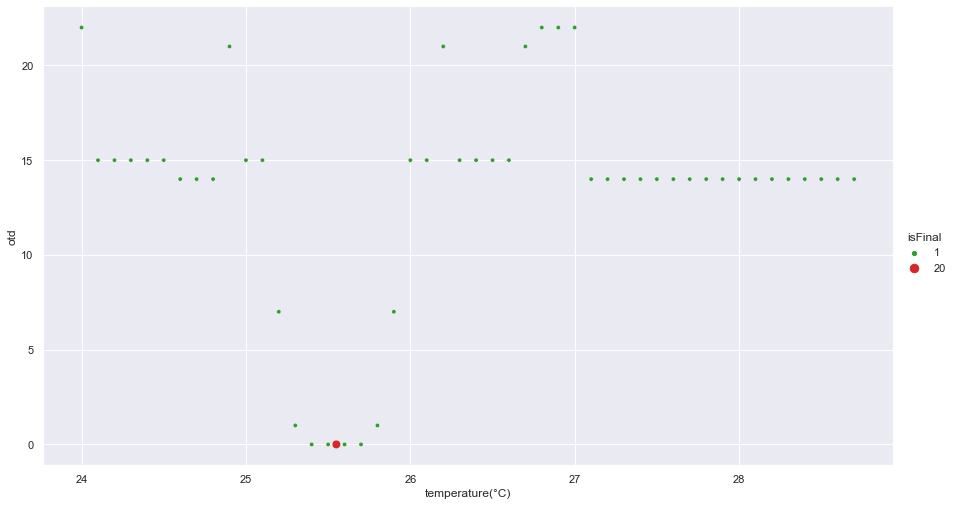

In [29]:
ogt.drawOtdValue()